## From LeNet, AlexNet and VGG to NIN

For LeNet, AlexNet and VGG they share a similar pattern, that is a set of convolutional blocks followed by a set of fully-connected layers. However, the fully-connected layers cannot maintain spacial information. So unless done with care, **using fully-connected layers too early in a network may cause an entire loss of spacial information**.

The NiN stands for Network in Network. **The idea of the NiN is to use an MLP on the channels for each pixel. The MLP is shared and slides over all pixels.**

**The MLP is shared among all receptive fields. A single layer perceptron on all pixels separately is equivalent to $1 \times 1$ convolution. And several $1 \times 1$ convolutions stacked is equivalent to MLP sliding on all pixels.**

## The mlpconv Block
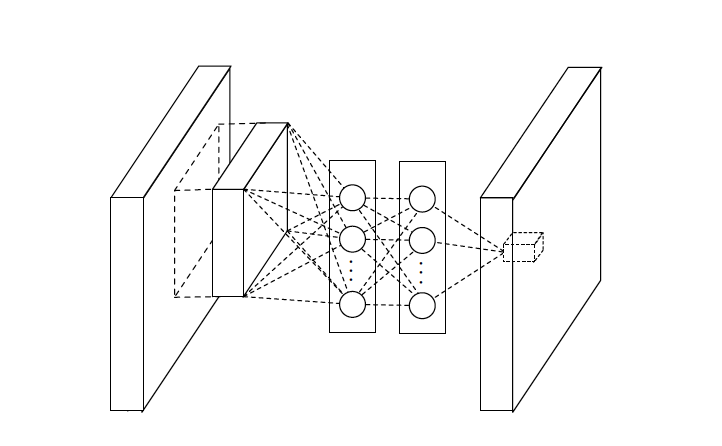

In [ ]:
import torch
from torch import nn
import torchvision

In [ ]:
def mlpconv(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),                                               
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
        )
    

## NIN model

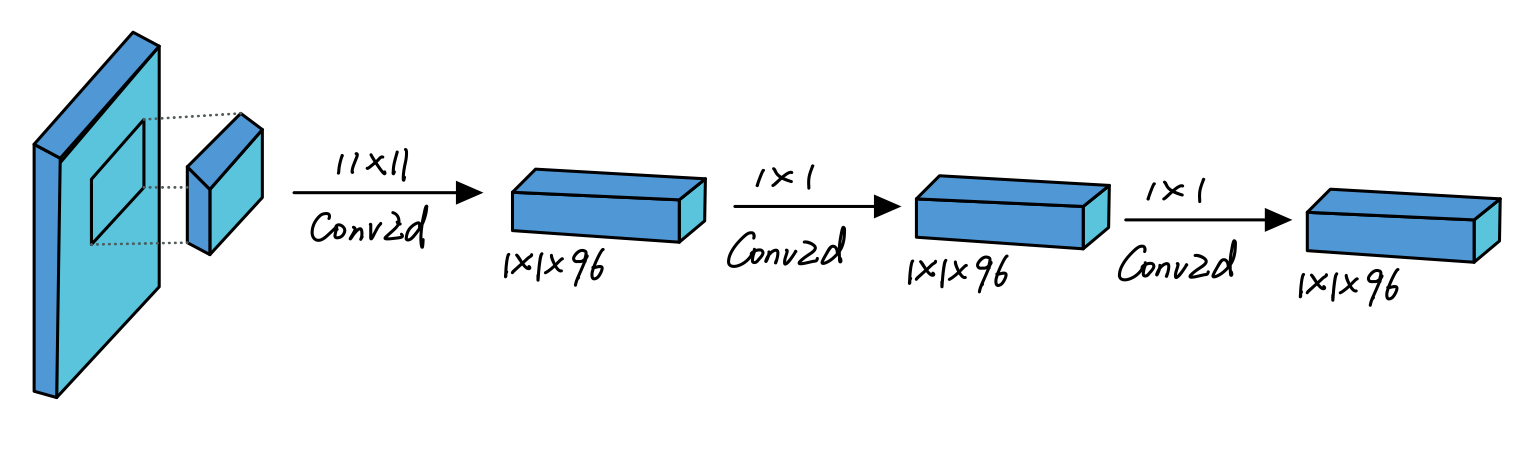

## Model

In [ ]:
net = nn.Sequential(
    mlpconv(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    mlpconv(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    mlpconv(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(3, stride=2), nn.Dropout(0.5),
    mlpconv(384, 10, kernel_size=3, stride=1, padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

## Dataset

In [ ]:
import sys
sys.path.append("../dlutils")
from dataset import load_fashion_mnist_dataset

batch_size = 128
train_loader, test_loader = load_fashion_mnist_dataset(batch_size=batch_size, resize=224)

## Loss

In [ ]:
loss = torch.nn.CrossEntropyLoss()

## Optimizer

In [ ]:
lr = 0.1
trainer = torch.optim.SGD(net.parameters(), lr=lr)

## Training

In [ ]:
from train import train_3ch
num_epochs = 120
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
loss.to(device)

train_3ch(net, loss, num_epochs, train_loader, trainer, test_loader, device)